In [1]:
!pip install fuzzywuzzy
!pip install koreanize-matplotlib

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
import pandas as pd
import numpy as np
import re
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import seaborn as sns

import koreanize_matplotlib

import matplotlib.font_manager as fm


# 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 환경
plt.rcParams['axes.unicode_minus'] = False    # 마이너스 기호 깨짐 방지
pd.set_option('display.max_columns', None)

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# 전국 병원 정보.csv

In [3]:
data01 = pd.read_csv("/content/전국 병원 정보.csv", encoding="cp949")
temp1 = data01.loc[data01['영업상태명']=="영업/정상"].copy().reset_index(drop=True)
temp1 = temp1[['번호','개방자치단체코드','영업상태명','소재지전체주소', '도로명전체주소', '업태구분명','진료과목내용명']]

temp1 = temp1.loc[temp1['진료과목내용명'].notna()]
temp2=temp1.copy()

# 진료과목내용명 데이터 정리
def clean_subject(subject):
    # (n개과) 또는 (n개과목) 제거
    subject = re.sub(r'\(.*?개과.*?\)', '', subject)
    # n개 진료 과목 제거
    subject = re.sub(r'\d+개 진료 과목', '', subject)
    # 특수문자 제거
    subject = re.sub(r'[^\w\s,가-힣]', '', subject)
    # '과' 형식으로 나타내기 위해 처리
    subject_list = [s.strip() for s in subject.split(',') if s.strip()]
    # 이미 '과'로 끝나는 항목 처리
    subject_list = [s if s.endswith('과') else s + '과' for s in subject_list]
    return ', '.join(subject_list)

# 데이터프레임에 적용
temp1['진료과목내용명'] = temp1['진료과목내용명'].apply(clean_subject)

# 진료과목 추출 및 분리
temp1['진료과목내용명'] = temp1['진료과목내용명'].str.replace('·', ',').str.replace('.', ',')
subject_list = temp1['진료과목내용명'].str.split(',\s*', expand=True).stack().unique()

In [4]:
# 원핫인코딩
for subject in subject_list:
    temp1[subject] = temp1['진료과목내용명'].apply(lambda x: 1 if subject in x else 0)

temp1

<ipython-input-4-1d93bf86c977>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp1[subject] = temp1['진료과목내용명'].apply(lambda x: 1 if subject in x else 0)
<ipython-input-4-1d93bf86c977>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp1[subject] = temp1['진료과목내용명'].apply(lambda x: 1 if subject in x else 0)
<ipython-input-4-1d93bf86c977>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usin

,번호,개방자치단체코드,영업상태명,소재지전체주소,도로명전체주소,업태구분명,진료과목내용명,내과,신경과,가정의학과외과 한방내과,한방안이비인후피부과,한방피부과,한방신경정신과,한방재활의학과,사상체질과 및 침구과,재활의학과,가정의학과,한방내과,한방부인과,일반외과,정신건강의학과,외과,정형외과,신경외과,성형외과산부인과,소아청소년과,안과,이비인후과,비뇨기과,마취과,영상의학과,진단검사의학과,직업환경의학과,치과,흉부외과,응급의학과,피부과,병리과,사상체질과,침구과,정신과,8개 진료과목 신경과,마취통증의학과,한방소아과,산부인과,한방과,한방안 이비인후 피부과,한방내과외7과,한방안 이비인후과,한반신경정신과,한방8과,한방안8228이비인후8228피부과,한방침구과,정신과 내과,산부인과10개 과목과,졍형외과,소아과,성형외과,치과보철과,치과보존과,치주과,치과교정과,소아치과,한방이비인후피부과,16개 과목\r\n내과,7개과목 한방내과,마취통증학과,직업환환의학과,진담감사의학과,한방안이비인후과,마취통증의학고과,구강악안면외과,구강악안면방사선과,구강내과,통증의학과,사상체질과및침구과,산업의학과,진단방사선과,핵의학과,방사선종양학과,한방안이비인후과피부과,한방재활의학과 사상체질과,한방안과,한방8개과,한발8개과,보철과,보존과,교정과,예방치과,소아과 한방내과,부인과,한방내과 등 7개 과목과,신경외과계 6개 과목과,전신건강의학과,흉부외과19개 과목과,신경외과계 15개 과목과,침구과가정의학과,한방 안 이비인후 피부과,가저의학과,소아과피부과,임상병리과,방사선과,응급의하과,진단검사의학과\r\n산부인과,작업환경의학과,가정의하과,예방의학과,기정의학과,성형외과재활의학과,한방 8개과,한방부인소아과,한방재활의학과9과,한방내과7과목과,마취통증의하과,한의과,한방정신과,침구과\r\n마취통증의학과,한방안8231이비인후8231피부과,신경내과,외과계 9개 과목과,비뇨기과 계 11과목과,소아창소년과,류마티스내과,순환기내과,소화기내과,신장내과,호홉기내과,결핵과,진단검사\r\n의학과,직업환경의학과22개 과목과,소아치과치주과,가정의학과 추가과,안이비인후피부과,신경정신과,청소년소아과,내과계 9개 과목과,해부병리과,구강병리과,신경과 진단검사의학과,치료방사선과,한방이비인후과,가정의힉과,14개과내과,사상체질의학과,신경과\r\n 한방내과,재활의학고과,내과 외과 가정의학과 정형외과 신경외과 피부과 한방내과,내과 외과 정형외과 신경외과 소아청소년과,정형외과 외과 신경외과 내과 재활의학과 마취통증의학과,재활의학과 내과 가정의학과 마취통증의학과,비뇨기과 내과 마취통증의학과 피부과 정형외과 외과 이비인후과 신경외과,외과 한방내과 정형외과 신경외과 재활의학과 내과 이비인후과 피부과,내과 외과 정형외과 신경외과 이비인후과 피부과 비뇨기과 정신건강의학과 소아청소년과 한방내과,한방내과 한방부인과 한방소아과 한방안이비인후피부과 한방신경정신과,정신건강의학화과,영상상의학과,4과목재활의학과,주요시설진료실3과,의무기록실과,조제실과,방사선실과,임상검사실과,소독시설과,운동치료실과,작업치료실과,통증치료실과,소아치료실과,조리실과,구급자동차과,일반내과,진단영상의학과,미취통증의학과,마취통증과,침구과4개 과목과,한방 안이비인후피부과,한방안이비인후 피부과,소화청소년과,8개과한방내과,마취통증의학과 일반외과,내과 신경괴과,한방내과 추가과,정신건강의하과,재활의학과 침구과,비뇨의학과,영상치의학과,한방응급과,심장혈관흉부외과,통합치의학과
3,2351,6480000,영업/정상,경상남도 통영시 도산면 도선리 211번지 1호 1호,경상남도 통영시 도산면 남해안대로 1818,요양병원(노인병원),"내과, 신경과, 가정의학과외과 한방내과, 한방안이비인후피부과, 한방피부과, 한방신경...",1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2352,6480000,영업/정상,132번지,경상남도 창원시 의창구 창원천로94번길 82-18 (대원동),요양병원(일반요양병원),"내과, 재활의학과, 신경과, 가정의학과, 한방내과, 한방부인과, 한방재활의학과, 사...",1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2353,6480000,영업/정상,경상남도 창원시 마산합포구 자산동 29번지 20호 20호,경상남도 창원시 마산합포구 무학로 402 (자산동),요양병원(노인병원),"일반외과, 가정의학과, 정신건강의학과, 한방내과, 사상체질과 및 침구과",1,0,0,0,0,0,0,1,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2356,6470000,영업/정상,NaN,경상북도 경주시 건천읍 단석로 1593-9,요양병원(일반요양병원),"내과, 외과, 가정의학과",1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2357,6470000,영업/정상,NaN,경상북도 경산시 중앙로16길 49 (삼북동),요양병원(일반요양병원),"내과, 외과, 신경과, 재활의학과, 한방내과",1,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [5]:
# 제공된 대분류 리스트
major_categories = [
    "내과", "신경과", "정신건강의학과", "외과", "정형외과", "신경외과", "심장혈관흉부외과",
    "성형외과", "마취통증의학과", "산부인과", "소아청소년과", "안과", "이비인후과", "피부과",
    "비뇨의학과", "영상의학과", "방사선종양학과", "병리과", "진단검사의학과", "재활의학과",
    "결핵과", "예방의학과", "가정의학과", "핵의학과", "직업환경의학과", "응급의학과",
    "구강악안면외과", "치과보철과", "치과교정과", "소아치과", "치주과", "치과보존과",
    "구강내과", "영상치의학과", "구강병리과", "예방치과", "통합치의학과",
    "한방내과", "한방부인과", "한방소아과", "한방안·이비인후·피부과", "한방신경정신과",
    "한방재활의학과", "사상체질과", "침구과"
]

# 유사 텍스트 매칭 함수
def fuzzy_map_columns(column_name):
    match, score = process.extractOne(column_name, major_categories)
    return match if score > 80 else "기타"  # 유사도가 80% 이상인 경우 매칭

# 진료과목 이름을 대분류로 자동 매핑
column_mapping = {col: fuzzy_map_columns(col) for col in temp1.columns}

# 제외할 칼럼 리스트 설정
exclude_columns = ['개방자치단체코드','영업상태명', '소재지전체주소', '도로명전체주소','업태구분명','진료과목내용명']

# 기존 테이블에서 대분류별 병합
for specific, general in column_mapping.items():
    if specific in exclude_columns:
        continue  # 제외할 칼럼이면 건너뜀

    # 특정 열(specific)이 포함된 데이터프레임 열의 타입을 정수로 변환
    temp1[specific] = temp1[specific].astype(int)  # 데이터 타입 통일

    if general in temp1.columns:
        # 이미 존재하는 대분류 열에 값 병합
        temp1[general] = temp1[general].astype(int) | temp1[specific]
    else:
        # 새 대분류 열 생성
        temp1[general] = temp1[specific]

# 세부 항목 열 삭제 (exclude_columns 포함 X)
temp1 = temp1[[col for col in temp1.columns if col in major_categories and col not in exclude_columns]]
temp1

<ipython-input-5-7f3a8c483dfa>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp1[general] = temp1[specific]
<ipython-input-5-7f3a8c483dfa>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp1[general] = temp1[specific]


,내과,신경과,한방신경정신과,한방재활의학과,재활의학과,가정의학과,한방내과,한방부인과,정신건강의학과,외과,정형외과,신경외과,소아청소년과,안과,이비인후과,영상의학과,진단검사의학과,직업환경의학과,응급의학과,피부과,병리과,사상체질과,침구과,마취통증의학과,한방소아과,산부인과,성형외과,치과보철과,치과보존과,치주과,치과교정과,소아치과,구강악안면외과,구강내과,핵의학과,방사선종양학과,예방치과,예방의학과,결핵과,구강병리과,비뇨의학과,영상치의학과,심장혈관흉부외과,통합치의학과,한방안·이비인후·피부과
3,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5361,1,1,0,0,1,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5362,0,0,1,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5363,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5364,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
concat_data = pd.concat([temp2, temp1], axis=1)
concat_data = concat_data.drop(columns=["진료과목내용명"])

# 소재지와 도로명에서 시도와 시군구 추출
concat_data['시도'] = concat_data['도로명전체주소'].str.split(' ').str[0]
concat_data['시군구'] = concat_data['도로명전체주소'].str.split(' ').str[1]
# '시도'가 NaN인 경우에만 값을 업데이트
concat_data.loc[concat_data['시도'].isna(), '시도'] = concat_data['소재지전체주소'].str.split(' ').str[0]
concat_data.loc[concat_data['시군구'].isna(), '시군구'] = concat_data['소재지전체주소'].str.split(' ').str[1]

concat_data = concat_data.drop(['번호','개방자치단체코드','영업상태명','소재지전체주소','도로명전체주소'], axis=1)

In [7]:
# 집계할 병원 열 선택 (업태구분명 제외, 실제 데이터의 병원 관련 열만 사용)
hospital_columns = [
    '내과', '신경과', '한방신경정신과', '한방재활의학과', '재활의학과', '가정의학과', '한방내과', '한방부인과',
    '정신건강의학과', '외과', '정형외과', '신경외과', '소아청소년과', '안과', '이비인후과', '영상의학과',
    '진단검사의학과', '직업환경의학과', '응급의학과', '피부과', '병리과', '사상체질과', '침구과', '마취통증의학과',
    '한방소아과', '산부인과', '성형외과', '치과보철과', '치과보존과', '치주과', '치과교정과', '소아치과',
    '구강악안면외과', '구강내과', '핵의학과', '방사선종양학과', '예방치과', '예방의학과', '결핵과', '구강병리과',
    '비뇨의학과', '영상치의학과', '심장혈관흉부외과', '통합치의학과', '한방안·이비인후·피부과'
]

# 시군구별 병원 개수 집계
result = concat_data.groupby(['시도', '시군구'])[hospital_columns].sum().reset_index()

# 시도별 합계 계산 후 추가
state_totals = result.groupby('시도')[hospital_columns].sum().reset_index()
state_totals['시군구'] = '소계'

# 시군구 데이터와 합계 데이터 병합
final_result = pd.concat([result, state_totals], ignore_index=True).sort_values(by=['시도', '시군구'])
final_result

,시도,시군구,내과,신경과,한방신경정신과,한방재활의학과,재활의학과,가정의학과,한방내과,한방부인과,정신건강의학과,외과,정형외과,신경외과,소아청소년과,안과,이비인후과,영상의학과,진단검사의학과,직업환경의학과,응급의학과,피부과,병리과,사상체질과,침구과,마취통증의학과,한방소아과,산부인과,성형외과,치과보철과,치과보존과,치주과,치과교정과,소아치과,구강악안면외과,구강내과,핵의학과,방사선종양학과,예방치과,예방의학과,결핵과,구강병리과,비뇨의학과,영상치의학과,심장혈관흉부외과,통합치의학과,한방안·이비인후·피부과
0,강원특별자치도,강릉시,5,2,0,0,3,4,0,4,5,5,4,4,2,3,3,5,2,0,3,3,3,0,0,3,0,4,2,3,1,1,0,0,3,0,1,1,0,0,0,0,4,0,2,0,0
1,강원특별자치도,동해시,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,강원특별자치도,삼척시,3,1,0,0,1,0,1,1,0,3,3,2,1,0,0,2,1,0,1,0,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
232,강원특별자치도,소계,65,22,5,6,31,34,16,24,22,54,41,34,16,8,13,27,13,4,13,15,7,5,10,23,4,20,8,13,6,5,2,4,10,1,4,4,2,0,0,0,10,1,7,3,4
3,강원특별자치도,속초시,4,2,0,0,1,1,1,2,2,4,2,2,2,0,2,2,2,0,2,0,1,0,0,3,0,2,1,2,1,1,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,충청북도,제천시,8,2,0,1,5,5,3,6,1,6,3,6,3,0,0,3,2,2,2,1,1,0,2,3,0,5,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1
228,충청북도,증평군,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
229,충청북도,진천군,1,1,0,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
230,충청북도,청주시,32,12,5,7,26,26,11,18,10,24,16,12,12,3,7,16,7,5,7,10,2,4,9,13,4,14,3,6,2,3,3,1,6,2,1,1,0,2,1,0,5,0,6,2,7


In [8]:
# merged_df를 CSV 파일로 저장
final_result.to_csv('의료_label.csv', index=False, encoding='utf-8-sig')

# 미충족 의료율(표준화)

In [9]:
df = pd.read_csv("/content/시·군·구별_연간_미충족의료율_병의원__19.csv")

df.columns = df.iloc[0]
df = df.drop(index=0).reset_index(drop=True)
df = df.rename(columns={'시군구별(1)': '시도', '시군구별(2)': '시군구'})

df = df[['시도', '시군구', '시군구별(3)', '표준화율 (%)']]
df['표준화율 (%)'] = pd.to_numeric(df['표준화율 (%)'], errors='coerce')
df = df[df['시군구별(3)'] == '소계']
df = df.drop(columns=['시군구별(3)'])
df


,시도,시군구,표준화율 (%)
0,서울특별시,소계,5.3
1,서울특별시,강남구,3.3
2,서울특별시,강동구,5.9
3,서울특별시,강북구,5.2
4,서울특별시,강서구,6.4
...,...,...,...
276,경상남도,함양군,9.3
277,경상남도,합천군,3.5
278,제주특별자치도,소계,4.7
279,제주특별자치도,서귀포시,5.5


In [10]:
df.to_csv('19년 의료미충족율 표준화 지수.csv', index=False, encoding='utf-8-sig')

# 표준화율 시각화

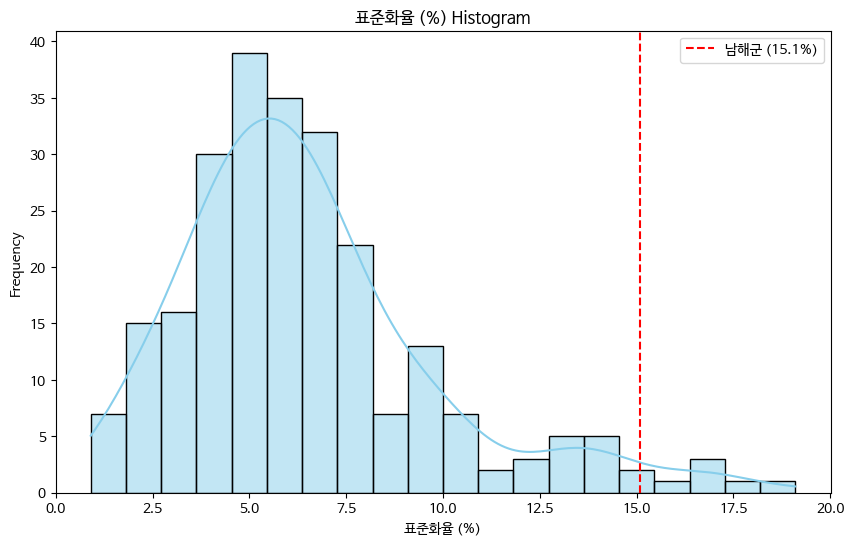

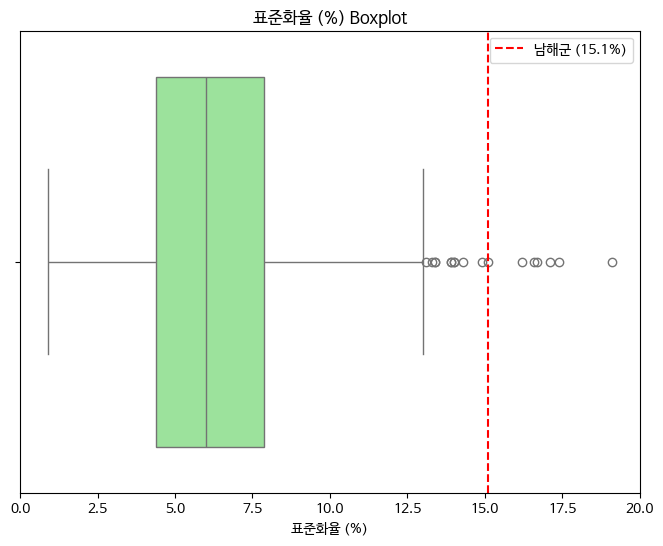

In [11]:
namhae_value = df[(df['시도'] == '경상남도') & (df['시군구'] == '남해군')]['표준화율 (%)'].values[0]

plt.rc('font', family='NanumBarunGothic')
# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['표준화율 (%)'], bins=20, kde=True, color='skyblue')
plt.axvline(namhae_value, color='red', linestyle='--', label=f'남해군 ({namhae_value}%)')
plt.title('표준화율 (%) Histogram')
plt.xlabel('표준화율 (%)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['표준화율 (%)'], color='lightgreen')
plt.axvline(namhae_value, color='red', linestyle='--', label=f'남해군 ({namhae_value}%)')
plt.title('표준화율 (%) Boxplot')
plt.xlabel('표준화율 (%)')
plt.legend()
plt.show()